# Alethea's Attempt at ResNet-50

In [1]:
import torch
from torch import nn
import matplotlib
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader

In [2]:
# CUDA for PyTorch
# Shamelessly stolen from: https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

## Let's Build the Model

I'm basing this on the resnet diagram from: https://cv-tricks.com/keras/understand-implement-resnets/

In [3]:
class ReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        return self.relu(x)

In [4]:
class ConvModule(nn.Module):
    """Implements a single Convolution layer"""

    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, bias=True, 
                 padding_mode='zeros'):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, 
                              stride, padding, dilation, groups, 
                              bias, padding_mode)

    def forward(self, x):
        return self.conv(x) # Do I need to add a ReLU in here? Maybe: ReLU().forward(self.conv(x))

In [5]:
tmpmodel = ConvModule(in_channels=3, out_channels=3, kernel_size=3)
print(list(tmpmodel.parameters()))

[Parameter containing:
tensor([[[[ 0.1853,  0.1046,  0.1594],
          [-0.0519,  0.1107,  0.1457],
          [-0.1332,  0.0412, -0.1808]],

         [[ 0.1114, -0.0705, -0.0286],
          [-0.1632,  0.1632,  0.1504],
          [-0.1345,  0.0420,  0.0812]],

         [[ 0.1296, -0.1712,  0.1588],
          [ 0.0552,  0.0629, -0.0097],
          [ 0.0524,  0.0306, -0.0389]]],


        [[[-0.0816,  0.0343,  0.0824],
          [-0.0102, -0.0513, -0.1574],
          [-0.0048, -0.1297,  0.1682]],

         [[-0.0383, -0.1338, -0.1482],
          [-0.1680,  0.1429,  0.0194],
          [ 0.1184, -0.0892, -0.1328]],

         [[-0.0336, -0.1044, -0.0857],
          [-0.0155,  0.1525, -0.0250],
          [ 0.0202, -0.0083, -0.1541]]],


        [[[ 0.0395,  0.1092,  0.0262],
          [-0.1111, -0.1796, -0.0465],
          [-0.1191,  0.0066,  0.0741]],

         [[-0.0662, -0.1818,  0.1393],
          [ 0.1094, -0.1797,  0.0236],
          [ 0.1498,  0.0932,  0.1711]],

         [[-0.1159,  

In [6]:
class MaxPoolModule(nn.Module):
    """Implements a single Max Pool layer"""

    def __init__(self, kernel_size, stride=None, padding=0, dilation=1, 
                 return_indices=False, ceil_mode=False):
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size, stride, padding, dilation, 
                                    return_indices, ceil_mode)

    def forward(self, x):
        return self.maxpool(x) 

In [7]:
class AvgPoolModule(nn.Module):
    """Implements a single Average Pool layer"""
    
    def __init__(self, kernel_size, stride=None, padding=0, ceil_mode=False, 
                 count_include_pad=True, divisor_override=None):
        super().__init__()
        self.avgpool = nn.AvgPool2d(kernel_size, stride, padding, ceil_mode, 
                                    count_include_pad, divisor_override)

    def forward(self, x):
        return self.avgpool(x) 

In [8]:
class LinearModule(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
    
    def forward(self, x):
        return self.linear(x)

In [9]:
tmpmodel = LinearModule(in_features=100, out_features=100)
print(list(tmpmodel.parameters()))

[Parameter containing:
tensor([[ 0.0499,  0.0341, -0.0661,  ..., -0.0750,  0.0978,  0.0443],
        [ 0.0509, -0.0479,  0.0918,  ..., -0.0515,  0.0850,  0.0674],
        [ 0.0031, -0.0396,  0.0509,  ...,  0.0324,  0.0362,  0.0512],
        ...,
        [-0.0789,  0.0364, -0.0853,  ...,  0.0929, -0.0862,  0.0977],
        [ 0.0304,  0.0141,  0.0957,  ...,  0.0577,  0.0024, -0.0056],
        [ 0.0358, -0.0427,  0.0407,  ..., -0.0480, -0.0390,  0.0121]],
       requires_grad=True), Parameter containing:
tensor([ 0.0359, -0.0070, -0.0599,  0.0538, -0.0694, -0.0319,  0.0354, -0.0046,
         0.0867, -0.0416, -0.0084,  0.0347,  0.0053, -0.0346,  0.0679, -0.0363,
         0.0531,  0.0228, -0.0205, -0.0747,  0.0276, -0.0854,  0.0121, -0.0139,
        -0.0780,  0.0320, -0.0809, -0.0797,  0.0631,  0.0027,  0.0783, -0.0102,
         0.0918, -0.0075, -0.0847,  0.0183, -0.0871, -0.0754, -0.0592, -0.0240,
         0.0610, -0.0806,  0.0302,  0.0074,  0.0927,  0.0112, -0.0728, -0.0516,
         0.08

In [10]:
class SoftmaxModule(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.softmax = nn.Softmax(dim)
    
    def forward(self, x):
        return self.softmax(x)

In [11]:
class ResidualModule(nn.Module):
    """Implements a single residual block from a given stage"""
    
    def __init__(self, stage_num):
        super().__init__()

        # p = parameters
        p = {1: {'in_channels': [64, 64, 64], 
                 'out_channels': [64, 64, 256], 
                 'kernel_size': [1, 3, 1],
                 'stride': [1] * 3, 
                 'padding': [1, 0, 0], 
                 'dilation': [1] * 3, 
                 'groups': [1] * 3, 
                 'bias': [True] * 3,
                 'padding_mode': ['zeros'] * 3 },
             2: {'in_channels': [128, 128, 128], 
                 'out_channels': [128, 128, 512], 
                 'kernel_size': [1, 3, 1],
                 'stride': [1] * 3, 
                 'padding': [1, 0, 0],
                 'dilation': [1] * 3, 
                 'groups': [1] * 3, 
                 'bias': [True] * 3,
                 'padding_mode': ['zeros'] * 3 },
             3: {'in_channels': [256,256, 256], 
                 'out_channels': [256, 256, 1024], 
                 'kernel_size': [1, 3, 1],
                 'stride': [1] * 3, 
                 'padding': [1, 0, 0], 
                 'dilation': [1] * 3, 
                 'groups': [1] * 3, 
                 'bias': [True] * 3,
                 'padding_mode': ['zeros'] * 3 },
             4: {'in_channels': [512, 512, 512], 
                 'out_channels': [512, 512, 2048], 
                 'kernel_size': [1, 3, 1],
                 'stride': [1] * 3, 
                 'padding': [1, 0, 0], 
                 'dilation': [1] * 3, 
                 'groups': [1] * 3, 
                 'bias': [True] * 3,
                 'padding_mode': ['zeros'] * 3 },
            }[stage_num]
        
        # Pytorch doesn't seem to be able to find trainable parameters if we put submodules 
        # into an array
        #
        # for i in range(3):
        #     self.layers.append()

        i = 0
        self.layer0 = ConvModule(p['in_channels'][i], p['out_channels'][i], p['kernel_size'][i], 
                                 p['stride'][i], p['padding'][i], p['dilation'][i], 
                                 p['groups'][i], p['bias'][i], p['padding_mode'][i])
        i = 1
        self.layer1 = ConvModule(p['in_channels'][i], p['out_channels'][i], p['kernel_size'][i], 
                                 p['stride'][i], p['padding'][i], p['dilation'][i], 
                                 p['groups'][i], p['bias'][i], p['padding_mode'][i])
        i = 2
        self.layer2 = ConvModule(p['in_channels'][i], p['out_channels'][i], p['kernel_size'][i], 
                                 p['stride'][i], p['padding'][i], p['dilation'][i], 
                                 p['groups'][i], p['bias'][i], p['padding_mode'][i])
        
                    
    def forward(self, x):
        a = x
        a = self.layer0.forward(a)
        a = self.layer1.forward(a)
        a = self.layer2.forward(a) 
        return a + x


In [12]:
class Stage(nn.Module):
    """Implements each of the four stages of residual blocks. 
    One instance of this class is one stage"""
    
    def __init__(self, stage_num):
        super().__init__()
    
        
        # Pytorch doesn't seem to be able to find trainable parameters if we put submodules 
        # into an array
        #
        # self.stage_num = stage_num
        #
        # self.num_blocks = {1: 3, 
        #                    2: 3, 
        #                    3: 6, 
        #                    4: 3}[stage_num]
        #
        # self.blocks = []
        # for i in range(self.num_blocks):
        #     self.blocks.append(ResidualModule(stage_num))

        self.block0 = ResidualModule(stage_num)
        self.block1 = ResidualModule(stage_num)
        self.block2 = ResidualModule(stage_num)
        if stage_num == 3:
            self.block3 = ResidualModule(stage_num)
            self.block4 = ResidualModule(stage_num)
            self.block5 = ResidualModule(stage_num)
            
        
    def forward(self, x):
        # a = x
        # for block in self.blocks:
        #     a = block.forward(x)
        # return a
        a = x
        a = self.block0.forward(a)
        a = self.block1.forward(a)
        a = self.block2.forward(a)
        if stage_num == 3:
            a = self.block3.forward(a)
            a = self.block4.forward(a)
            a = self.block5.forward(a)
        return a

In [13]:
class ResNet50(nn.Module):

    def __init__(self, num_labels):
        super().__init__()
        
        # 7x7 Conv
        self.layer1 = ConvModule(in_channels=3, out_channels=64, 
                                 kernel_size=7, stride=2, padding=4)

        # 3x3 MaxPool
        self.layer2 = MaxPoolModule(kernel_size=3, stride=2, padding=1)

        # Residual Stages
        self.stage1 = Stage(1)
        self.stage2 = Stage(2)
        self.stage3 = Stage(3)
        self.stage4 = Stage(4)

        # AveragePool
        self.avgpool = AvgPoolModule(kernel_size=7)  # FIXME
        
        # Fully Connected
        self.linear = LinearModule(in_features=1000, out_features=num_labels)
        
        # I think this one is handled by choosing criterion = nn.CrossEntropyLoss() below
        # self.softmax = SoftmaxModule(dim=num_labels)  # Is this needed? 

    def forward(self, x):
        a = x
        a = self.layer1.forward(a)
        a = self.layer2.forward(a)
        a = self.stage1.forward(a)
        a = self.stage2.forward(a)
        a = self.stage3.forward(a)
        a = self.stage4.forward(a)
        a = self.avgpool.forward(a)
        a = self.linear.forward(a)
        a = self.softmax.forward(a)
        return a

## Load our data. 

I'm using advice from https://www.learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/ about regularizing image data. 


In [14]:
transform = transforms.Compose([transforms.Resize(256),        
                                transforms.CenterCrop(224),    
                                transforms.ToTensor(),         
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],    
                                                     std=[0.229, 0.224, 0.225])
                               ])


datadir = "/home/apower/data/oxford-iiit-pet"
traindir = os.path.join(datadir, 'train')
devdir = os.path.join(datadir, 'dev')
testdir = os.path.join(datadir, 'test')

X_train = torchvision.datasets.ImageFolder(traindir, transform)
X_dev = torchvision.datasets.ImageFolder(devdir, transform)
X_test = torchvision.datasets.ImageFolder(testdir, transform)

# It's better to pre-divide data into train/dev/test. That way it doesn't randomly shift between runs. 

#dataset = torchvision.datasets.ImageFolder(datadir, transform)
#total_pics = len(dataset)
#test_pics = int(min(total_pics * .1, 1000))
#dev_pics = int(min(total_pics * .1, 1000))
#train_pics = total_pics - (dev_pics + test_pics)
#(X_train, X_dev, X_test) = torch.utils.data.random_split(dataset, (train_pics, dev_pics, test_pics))

In [15]:
print('training_set:', len(X_train), '\ndev_set:', len(X_dev), '\ntest_set:', len(X_test))

training_set: 5760 
dev_set: 800 
test_set: 800


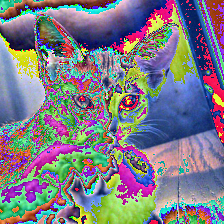

In [16]:
to_pic = torchvision.transforms.ToPILImage()
to_pic(X_train[0][0])

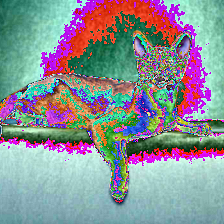

In [17]:
to_pic(X_dev[0][0])

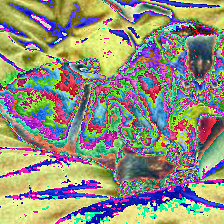

In [18]:
to_pic(X_test[0][0])

## Let's Do it


In [19]:
model = ResNet50(num_labels=len(X_train.classes))
model.cuda()

ResNet50(
  (layer1): ConvModule(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(4, 4))
  )
  (layer2): MaxPoolModule(
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Stage(
    (block0): ResidualModule(
      (layer0): ConvModule(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      )
      (layer1): ConvModule(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (layer2): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (block1): ResidualModule(
      (layer0): ConvModule(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      )
      (layer1): ConvModule(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (layer2): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (block2): ResidualModul

In [20]:
print(model)


ResNet50(
  (layer1): ConvModule(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(4, 4))
  )
  (layer2): MaxPoolModule(
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Stage(
    (block0): ResidualModule(
      (layer0): ConvModule(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      )
      (layer1): ConvModule(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (layer2): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (block1): ResidualModule(
      (layer0): ConvModule(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
      )
      (layer1): ConvModule(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (layer2): ConvModule(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (block2): ResidualModul

In [21]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[ 6.7332e-02,  1.5142e-02,  7.7828e-03,  ...,  7.1579e-02,
            1.7173e-02, -3.1085e-02],
          [ 1.6381e-02,  6.9619e-02, -6.4914e-02,  ..., -3.4596e-02,
           -6.7089e-02, -4.4889e-02],
          [-6.3234e-02,  2.0680e-03, -8.0974e-02,  ..., -8.6590e-03,
            1.7491e-02,  3.1360e-02],
          ...,
          [-8.0755e-03,  1.0963e-02,  2.7708e-03,  ..., -6.5802e-02,
           -3.0025e-02,  4.1935e-02],
          [-1.5976e-04, -5.3277e-02,  7.4078e-03,  ...,  6.0383e-02,
            1.0573e-02,  6.6453e-02],
          [ 1.5046e-02,  3.0703e-02,  6.5412e-02,  ...,  5.1569e-02,
            7.8698e-02,  1.8774e-02]],

         [[-2.1547e-02, -1.1834e-02,  6.8345e-03,  ..., -8.0738e-02,
           -5.3112e-03,  6.3040e-02],
          [-3.5936e-03, -7.9259e-02,  4.3452e-03,  ..., -6.9540e-02,
            2.3503e-02,  1.6563e-02],
          [-3.5023e-02,  7.5503e-02,  1.8231e-02,  ..., -7.2129e-02,
            3.4891e-02,  4.8643e-03]

Parameter containing:
tensor([[[[-0.0274, -0.0380,  0.0074],
          [-0.0267,  0.0218, -0.0144],
          [-0.0085, -0.0285, -0.0037]],

         [[-0.0167, -0.0015, -0.0194],
          [-0.0251,  0.0264,  0.0192],
          [-0.0221, -0.0279, -0.0067]],

         [[ 0.0239, -0.0390, -0.0055],
          [-0.0171, -0.0140, -0.0360],
          [-0.0369, -0.0323,  0.0268]],

         ...,

         [[-0.0345, -0.0058, -0.0409],
          [ 0.0331,  0.0170, -0.0238],
          [ 0.0395,  0.0049,  0.0213]],

         [[-0.0329,  0.0140,  0.0156],
          [-0.0229, -0.0130,  0.0081],
          [-0.0005, -0.0039,  0.0335]],

         [[-0.0179, -0.0003, -0.0340],
          [-0.0016,  0.0104, -0.0196],
          [-0.0320,  0.0048,  0.0048]]],


        [[[-0.0417,  0.0032, -0.0365],
          [ 0.0145,  0.0034, -0.0382],
          [-0.0096,  0.0261, -0.0411]],

         [[-0.0199,  0.0205,  0.0129],
          [ 0.0125,  0.0274, -0.0217],
          [ 0.0156, -0.0131, -0.0378]],

         

Parameter containing:
tensor([-0.0516, -0.0193,  0.0478,  0.0512, -0.0171,  0.0583, -0.0784,  0.0855,
         0.0276, -0.0062,  0.0816, -0.0361, -0.0334,  0.0686,  0.0467,  0.0060,
         0.0489, -0.0569,  0.0173, -0.0524, -0.0766, -0.0867, -0.0728, -0.0537,
         0.0315, -0.0629, -0.0430, -0.0535,  0.0692,  0.0598, -0.0737, -0.0316,
         0.0272, -0.0525,  0.0073, -0.0387, -0.0236, -0.0064,  0.0185, -0.0547,
         0.0345, -0.0495,  0.0354,  0.0791,  0.0004,  0.0019,  0.0523, -0.0471,
        -0.0388, -0.0596, -0.0467,  0.0777,  0.0598,  0.0815, -0.0760,  0.0634,
         0.0881, -0.0674, -0.0282,  0.0476, -0.0163,  0.0477,  0.0020,  0.0271,
        -0.0790,  0.0131, -0.0779, -0.0313,  0.0689,  0.0815,  0.0423,  0.0363,
        -0.0271, -0.0437, -0.0254,  0.0670,  0.0759,  0.0198,  0.0075,  0.0092,
        -0.0466,  0.0413,  0.0267,  0.0413, -0.0777,  0.0153,  0.0651,  0.0115,
         0.0096, -0.0436, -0.0009,  0.0265, -0.0284,  0.0644, -0.0655,  0.0318,
         0.0150, -

Parameter containing:
tensor([[[[ 0.0265]],

         [[-0.0346]],

         [[-0.0119]],

         ...,

         [[-0.0025]],

         [[ 0.0459]],

         [[-0.0127]]],


        [[[-0.0047]],

         [[-0.0255]],

         [[ 0.0051]],

         ...,

         [[-0.0130]],

         [[ 0.0582]],

         [[-0.0404]]],


        [[[ 0.0610]],

         [[-0.0059]],

         [[-0.0506]],

         ...,

         [[ 0.0448]],

         [[ 0.0286]],

         [[ 0.0233]]],


        ...,


        [[[ 0.0489]],

         [[-0.0447]],

         [[-0.0584]],

         ...,

         [[-0.0211]],

         [[-0.0458]],

         [[-0.0583]]],


        [[[ 0.0293]],

         [[-0.0396]],

         [[ 0.0515]],

         ...,

         [[-0.0507]],

         [[ 0.0532]],

         [[-0.0146]]],


        [[[ 0.0175]],

         [[-0.0032]],

         [[ 0.0605]],

         ...,

         [[ 0.0065]],

         [[-0.0591]],

         [[ 0.0017]]]], device='cuda:0', requires_grad=Tru

Parameter containing:
tensor([[[[-4.7450e-03, -3.2027e-03, -4.0461e-03],
          [ 1.8269e-02,  1.7219e-02,  1.3572e-02],
          [-5.3413e-03, -7.1298e-03, -1.5115e-02]],

         [[-1.1884e-02,  7.6476e-03, -4.2292e-03],
          [-2.0063e-02,  6.5467e-03,  9.1048e-03],
          [-3.0944e-03,  6.4350e-03,  1.1185e-02]],

         [[ 1.4191e-03,  9.2904e-03, -2.0102e-02],
          [ 9.0434e-03, -5.2588e-03, -1.0160e-02],
          [-1.3352e-02, -6.4888e-03,  7.5159e-03]],

         ...,

         [[ 1.0719e-02,  1.2663e-02, -1.6345e-02],
          [-1.8652e-02, -1.5506e-02, -6.0804e-03],
          [ 8.4540e-03,  3.5428e-03,  9.0213e-03]],

         [[-1.9791e-02,  1.1104e-02,  1.8586e-02],
          [-1.8530e-02, -6.7452e-03,  1.4881e-02],
          [ 2.2530e-03, -7.4731e-03, -7.5115e-03]],

         [[ 1.1887e-02, -1.0336e-02, -5.9584e-03],
          [ 1.0126e-02, -1.4057e-02,  1.9336e-02],
          [ 1.5595e-02,  1.2932e-02,  9.3510e-03]]],


        [[[-5.3698e-03,  3.8484

Parameter containing:
tensor([[[[ 0.0625]],

         [[ 0.0535]],

         [[ 0.0215]],

         ...,

         [[ 0.0137]],

         [[ 0.0173]],

         [[ 0.0375]]],


        [[[ 0.0601]],

         [[ 0.0250]],

         [[-0.0206]],

         ...,

         [[-0.0014]],

         [[-0.0540]],

         [[-0.0110]]],


        [[[-0.0516]],

         [[-0.0017]],

         [[ 0.0468]],

         ...,

         [[-0.0271]],

         [[ 0.0484]],

         [[ 0.0421]]],


        ...,


        [[[ 0.0613]],

         [[-0.0472]],

         [[-0.0363]],

         ...,

         [[-0.0343]],

         [[-0.0340]],

         [[ 0.0574]]],


        [[[ 0.0375]],

         [[ 0.0610]],

         [[ 0.0105]],

         ...,

         [[ 0.0047]],

         [[-0.0099]],

         [[-0.0597]]],


        [[[-0.0219]],

         [[ 0.0379]],

         [[ 0.0037]],

         ...,

         [[-0.0607]],

         [[ 0.0530]],

         [[-0.0435]]]], device='cuda:0', requires_grad=Tru

Parameter containing:
tensor([[[[-1.5225e-02, -1.1128e-02, -1.8634e-02],
          [ 7.4183e-03,  8.7088e-03,  1.1836e-03],
          [-9.2209e-03, -1.3327e-02, -3.9759e-04]],

         [[-5.5138e-03, -5.9350e-03,  3.8937e-03],
          [-1.2547e-03,  1.6395e-02,  7.3985e-03],
          [ 2.2012e-03,  1.9665e-02,  8.1412e-03]],

         [[ 8.3036e-03,  2.0305e-02, -2.0810e-02],
          [ 1.2560e-04, -2.5480e-03, -4.2190e-03],
          [ 4.0827e-03, -1.7654e-02, -1.0412e-02]],

         ...,

         [[ 7.4335e-03,  9.0932e-04,  4.0968e-03],
          [ 2.0081e-03, -1.9188e-02,  1.0750e-02],
          [ 9.4330e-03, -3.4711e-03,  1.7186e-04]],

         [[-1.1820e-02, -1.8997e-02,  3.8138e-03],
          [ 1.5660e-02,  1.0964e-02,  2.9627e-03],
          [ 2.9142e-03,  1.3948e-02, -9.6041e-03]],

         [[-3.3632e-03, -8.7737e-03,  1.4707e-02],
          [ 1.5749e-02, -1.9984e-02, -7.7596e-03],
          [ 9.6464e-03, -1.6375e-02, -1.2931e-03]]],


        [[[ 8.1958e-03,  1.4328

Parameter containing:
tensor([-1.7397e-02,  2.6531e-03,  1.5350e-02, -8.3376e-03,  1.9362e-02,
         1.7524e-02, -5.3465e-03,  1.8031e-02, -2.3218e-02, -3.0849e-02,
        -1.9173e-02, -1.7651e-02,  4.0828e-02,  2.7360e-02,  2.8709e-02,
        -7.2990e-03,  3.7840e-02, -1.3877e-02, -2.9488e-02,  3.4092e-02,
        -2.3114e-02,  1.2864e-02,  1.6277e-03,  3.3681e-02, -2.2849e-02,
        -2.2796e-02,  7.4524e-03,  6.1467e-03, -2.0667e-02, -2.9982e-02,
        -3.2236e-02, -4.3999e-02,  1.6933e-03,  1.1039e-02,  6.3147e-05,
         7.4819e-03, -1.2724e-02,  3.3697e-02, -2.6457e-03,  4.0161e-02,
         8.9492e-03,  3.4956e-02, -2.6190e-02,  3.2754e-02, -2.5718e-02,
         3.4847e-02,  5.4909e-04, -2.8382e-02,  3.7590e-02, -1.5868e-02,
         4.0086e-03,  3.4714e-02,  2.3532e-02,  4.8983e-03,  1.2307e-02,
         1.7855e-02, -3.6042e-03, -3.1593e-03, -1.8586e-04, -2.0792e-02,
         2.1637e-02,  1.0747e-02, -1.5722e-03,  5.9319e-04, -2.3514e-02,
         1.2811e-02, -4.1796e

Parameter containing:
tensor([[[[-1.4317e-02, -3.1285e-03, -7.9852e-03],
          [ 1.0504e-02,  1.1647e-02, -5.6763e-03],
          [ 1.4232e-02,  9.8199e-03,  2.0926e-03]],

         [[ 1.3529e-02,  6.0267e-03,  8.6286e-04],
          [-1.0497e-02,  1.2975e-02,  7.3410e-03],
          [-3.1355e-03, -1.1963e-02, -4.1804e-03]],

         [[ 1.3470e-03,  1.3095e-02,  1.4600e-02],
          [-7.9874e-03, -1.3538e-02,  1.3237e-02],
          [ 6.1618e-03, -9.2533e-03, -5.4475e-04]],

         ...,

         [[ 1.4868e-03,  1.5262e-03, -4.8641e-03],
          [ 7.0492e-03,  5.9839e-03,  1.0327e-02],
          [ 1.0513e-02,  1.2366e-02, -4.4316e-03]],

         [[-9.0510e-03,  9.7934e-04,  1.3837e-02],
          [-1.3561e-02,  1.3464e-02,  1.3044e-02],
          [ 6.5430e-03,  2.2132e-05, -1.3535e-02]],

         [[-2.8512e-03, -1.3801e-02, -6.6512e-03],
          [-9.5186e-03, -1.2619e-02, -4.6414e-03],
          [ 9.5052e-03, -1.2724e-02, -6.4990e-03]]],


        [[[-3.4675e-03,  3.7991

Woohoo!!!! We have parameters! :-D

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [23]:
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)
dev_loader = DataLoader(X_dev, batch_size=1, shuffle=True)
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

max_epochs = 100

losses = []
for epoch in range(max_epochs):
    for local_batch, local_labels in train_loader:
        # Transfer to GPU
        X, y = local_batch.to(device), local_labels.to(device)
        y_pred = model.forward(X)
        loss = criterion(y_pred, y)
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch:', epoch, 'loss:', loss.item())


RuntimeError: The size of tensor a (256) must match the size of tensor b (64) at non-singleton dimension 1